## Data Collection

The data used in this report was pulled from TMDB (https://www.themoviedb.org) using their public API. To be able to use the API, we created a user and sent a GET request to the authentications endpoint (https://api.themoviedb.org/3/authentication). By doing this, we were able to confirm proper client setup. Furthermore, we conducted GET requests to the endpoint (https://api.themoviedb.org/3/discover/movie) to get as many records as possible. We stored those records in CSV format.

The data collected has the following features:

GenreIds: This is a list of different genres applicable to the movie. The map between genre id and genre is below:

- Action          28
- Adventure       12
- Animation       16
- Comedy          35
- Crime           80
- Documentary     99
- Drama           18
- Family          10751
- Fantasy         14
- History         36
- Horror          27
- Music           10402
- Mystery         9648
- Romance         10749
- Science Fiction 878
- TV Movie        10770
- Thriller        53
- War             10752
- Western         37

Id: this is the unique identifier for each movie
OriginalLanguage: The movie's original language
OriginalTitle: The movie's title
Overview: short description of the movie content
Popularity: it is a metric used to measure how popular the movie is, it takes into account the following aspects

- Number of votes for the day
- Number of views for the day
- Number of users who marked it as a "favorite" for the day
- Number of users who added it to their "watchlist" for the day
- Release date
- Number of total votes
- Previous days score

ReleaseDate: movie data of release
Title: title of the movie
VoteAverage: It's the average of all of the TMDb user ratings
VoteCount: number of people who voted for the movie

In [23]:
# Import libraries
import seaborn as sns
import numpy as np
import ast
import csv
import os
import pandas as pd
import requests
import warnings
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Checking API Authentication
api_token = os.environ['API_TMDB_TOKEN']

url = "https://api.themoviedb.org/3/authentication"

headers = {
    "accept": "application/json",
    "Authorization": f"Bearer {api_token}"
}

response = requests.get(url, headers=headers)

print(response.text)

{"success":true,"status_code":1,"status_message":"Success."}


In [4]:
# Funtions to handle the data retrieval

def create_dict(data):
    '''This funtion creates a list of dictionaries from the request response'''
    result = {}
    movies = []
    for movie in data:
        result['GenreIds'] = movie.get('genre_ids', None)
        result['Id'] = movie.get('id', None)
        result['OriginalLanguage'] = movie.get('original_language', None)
        result['OriginalTitle'] = movie.get('original_title', None)
        result['Overview'] = movie.get('overview', None)
        result['Popularity'] = movie.get('popularity', None)
        result['ReleaseDate'] = movie.get('release_date', None)
        result['Title'] = movie.get('title', None)
        result['VoteAverage'] = movie.get('vote_average', None)
        result['VoteCount'] = movie.get('vote_count', None)
        movies.append(result)
        result = {}
    return movies

def store_in_CSV(file_name, posts, fields):
    '''This function stores a list of dictionaries in CSV format'''
    with open(file_name, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fields)
        if csvfile.tell() == 0:
            writer.writeheader()
        writer.writerows(posts)

def retrive_movies_data(headers):
    '''This function retrieves data form the /discover endpoint and process it into a CSV file'''
    page = 1
    url = "https://api.themoviedb.org/3/discover/movie?include_adult=false&include_video=false&language=en-US&sort_by=popularity.desc"
    fields = ['GenreIds', 'Id', 'OriginalLanguage', 'OriginalTitle', 'Overview', 'Popularity', 'ReleaseDate', 'Title', 'VoteAverage', 'VoteCount']

    while True:
        final_url = url + f"&page={page}"
        res = requests.get(final_url, headers=headers)
        json_res = res.json()
        data = json_res.get("results", [])
        if len(data) == 0:
            break
        dic_data = create_dict(data)
        page += 1
        store_in_CSV('movies.csv',dic_data, fields)

def create_movie_dict(data):
    '''This funtion creates a list of dictionaries from the request response'''
    result = {}
    movies = []
    for movie in data:
        result['Id'] = movie.get('id', None)
        result['Budget'] = movie.get('budget', None)
        result['ProductionCompanies'] = movie.get('production_companies', None)
        result['ProductionCountries'] = movie.get('production_countries', None)
        result['SpokenLanguages'] = movie.get('spoken_languages', None)
        result['TagLine'] = movie.get('tagline', None)
        result['RunTime'] = movie.get('runtime', None)
        result['Revenue'] = movie.get('revenue', None)
        movies.append(result)
        result = {}
    return movies


def get_data_by_id(headers, ids):
    '''This function retrieves data form the /movie/id endpoint and process it into a CSV file'''
    url = 'https://api.themoviedb.org/3/movie/'
    fields = ['Id', 'Budget', 'ProductionCompanies', 'ProductionCountries', 'SpokenLanguages', 'TagLine', 'RunTime', 'Revenue']
    all_movies = []

    for id in ids:
        final_url = url + f"{id}"
        res = requests.get(final_url, headers=headers)
        json_res = res.json()
        all_movies.append(json_res)
    dic_data = create_movie_dict(all_movies)
    store_in_CSV('movie_details.csv',dic_data, fields)

In [ ]:
# running this function creates a movies.csv in the same folder
retrive_movies_data(headers)

In [25]:
# Initial Dataset review
df_init = pd.read_csv('movies.csv')
print(df_init.shape)
df_init.head()

(10000, 10)


,GenreIds,Id,OriginalLanguage,OriginalTitle,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount
0,"[28, 12, 53]",299054,en,Expend4bles,Armed with every weapon they can get their han...,3741.062,2023-09-15,Expend4bles,6.4,364
1,"[28, 53, 80]",926393,en,The Equalizer 3,Robert McCall finds himself at home in Souther...,2471.515,2023-08-30,The Equalizer 3,7.3,1027
2,"[16, 28, 14]",1034062,en,Mortal Kombat Legends: Cage Match,"In 1980s Hollywood, action star Johnny Cage is...",2223.430,2023-10-17,Mortal Kombat Legends: Cage Match,7.8,27
3,"[28, 53]",575264,en,Mission: Impossible - Dead Reckoning Part One,Ethan Hunt and his IMF team embark on their mo...,2032.927,2023-07-08,Mission: Impossible - Dead Reckoning Part One,7.7,1799
4,"[53, 18]",1151534,es,Nowhere,A young pregnant woman named Mia escapes from ...,1627.678,2023-09-29,Nowhere,7.6,686


In [6]:
# getting the list of movie ids
ids = list(df_init['Id'])

In [ ]:
# getting second dataset with movie details
get_data_by_id(headers, ids)

In [26]:
# Chencking movie details data

df_movies = pd.read_csv('movie_details.csv')
print(df_movies.shape)
df_movies.head()

(10000, 8)


,Id,Budget,ProductionCompanies,ProductionCountries,SpokenLanguages,TagLine,RunTime,Revenue
0,299054,100000000,"[{'id': 1020, 'logo_path': '/kuUIHNwMec4dwOLgh...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...",They'll die when they're dead.,103,30000000
1,926393,70000000,"[{'id': 1423, 'logo_path': '/1rbAwGQzrNvXDICD6...","[{'iso_3166_1': 'IT', 'name': 'Italy'}, {'iso_...","[{'english_name': 'English', 'iso_639_1': 'en'...",Justice knows no borders.,109,176933602
2,1034062,0,"[{'id': 2785, 'logo_path': '/l5zW8jjmQOCx2dFmv...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...",Neon lights... Suits with shoulder pads... Jum...,80,0
3,575264,291000000,"[{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'French', 'iso_639_1': 'fr',...",We all share the same fate.,164,567148955
4,1151534,0,"[{'id': 204005, 'logo_path': None, 'name': 'Ro...","[{'iso_3166_1': 'ES', 'name': 'Spain'}]","[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Attempting to survive in the middle of nowhere...,109,0


## Data Wrangling

In this section, we conducted several steps to clean up and prepare the data for analysis. The steps we followed are listed below:

1. Merge data sets: So far, we have two CSV files, one with overall movie information and one with detailed movie data. We wanted to merge these two datasets using the movie "Id" as the primary key.
2. Features and datatypes: In this steps we will process features into the proper data type, inspecting and correcting invalid values
3. Inspect and impute nulls
4. Inspect and correct duplicated rows
5. create a new cleaned dataset (movies_cleaned.csv)



### 1. Merge Datasets

In [27]:
def inner_join(df1, df2, pk):
    '''This methods performs inner joint, based on given primery key'''
    return pd.merge(df1, df2, on=pk)

In [77]:
# Perform inner join to consolidate one single dataset
df = inner_join(df_init, df_movies, 'Id')
print(df.shape)
df.head(1)

(10000, 17)


,GenreIds,Id,OriginalLanguage,OriginalTitle,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount,Budget,ProductionCompanies,ProductionCountries,SpokenLanguages,TagLine,RunTime,Revenue
0,"[28, 12, 53]",299054,en,Expend4bles,Armed with every weapon they can get their han...,3741.062,2023-09-15,Expend4bles,6.4,364,100000000,"[{'id': 1020, 'logo_path': '/kuUIHNwMec4dwOLgh...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...",They'll die when they're dead.,103,30000000


### 2. Features and datatypes:

In [78]:
# create a list with the columns of the Dataframe
columns = df.columns

In [79]:
# Review the dataframe datatypes

df.dtypes

GenreIds                object
Id                       int64
OriginalLanguage        object
OriginalTitle           object
Overview                object
Popularity             float64
ReleaseDate             object
Title                   object
VoteAverage            float64
VoteCount                int64
Budget                   int64
ProductionCompanies     object
ProductionCountries     object
SpokenLanguages         object
TagLine                 object
RunTime                  int64
Revenue                  int64
dtype: object

In [80]:
# correcting the datetype for the column ReleaseDate

df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'])

In [81]:
# categorical columns inspection

categorical_df = df.select_dtypes(include='object')
categorical_df.head(1)

,GenreIds,OriginalLanguage,OriginalTitle,Overview,Title,ProductionCompanies,ProductionCountries,SpokenLanguages,TagLine
0,"[28, 12, 53]",en,Expend4bles,Armed with every weapon they can get their han...,Expend4bles,"[{'id': 1020, 'logo_path': '/kuUIHNwMec4dwOLgh...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...",They'll die when they're dead.


In [35]:
# reviewing unique values in each category to stablish category relevancy, text columns excluded to process in further steps

categorical_columns = categorical_df.columns
text_columns = ['Overview', 'Title', 'OriginalTitle', 'TagLine']

for column in categorical_columns:
    if column not in text_columns:
        print(f"----Unique values for column {column} -----")
        print(categorical_df[column].unique()[:5])

----Unique values for column GenreIds -----
['[28, 12, 53]' '[28, 53, 80]' '[16, 28, 14]' '[28, 53]' '[53, 18]']
----Unique values for column OriginalLanguage -----
['en' 'es' 'ko' 'hi' 'de']
----Unique values for column ProductionCompanies -----
["[{'id': 1020, 'logo_path': '/kuUIHNwMec4dwOLghDhhZJzHZTd.png', 'name': 'Millennium Media', 'origin_country': 'US'}, {'id': 48738, 'logo_path': None, 'name': 'Campbell Grobman Films', 'origin_country': 'US'}, {'id': 1632, 'logo_path': '/cisLn1YAUuptXVBa0xjq7ST9cH0.png', 'name': 'Lionsgate', 'origin_country': 'US'}]"
 "[{'id': 1423, 'logo_path': '/1rbAwGQzrNvXDICD6HWEn1YqfAV.png', 'name': 'Escape Artists', 'origin_country': 'US'}, {'id': 5, 'logo_path': '/wrweLpBqRYcAM7kCSaHDJRxKGOP.png', 'name': 'Columbia Pictures', 'origin_country': 'US'}, {'id': 10400, 'logo_path': '/9LlB2YAwXTkUAhx0pItSo6pDlkB.png', 'name': 'Eagle Pictures', 'origin_country': 'IT'}, {'id': 44967, 'logo_path': None, 'name': 'ZHIV Productions', 'origin_country': ''}]"
 "[{'i

In [82]:
# eliminate SpokenLanguages as there is already a column for original language and we believe the translations may not be predictive to the model
df.drop('SpokenLanguages', axis=1, inplace=True)

In [83]:
# preprocessing of column 'GenreIds'

# We created the new columns in the DataFrame, one column per genre (one-hot encoding)

genre_map = {
    28: 'Action',
    12: 'Adventure',
    16: 'Animation',
    35: 'Comedy',
    80: 'Crime',
    99: 'Documentary',
    18: 'Drama',
    10751: 'Family',
    14: 'Fantasy',
    36: 'History ',
    27: 'Horror',
    10402: 'Music',
    9648: 'Mystery',
    10749: 'Romance',
    878: 'ScienceFiction',
    10770: 'TvMovie',
    53: 'Thriller',
    10752: 'War',
    37: 'Western'
}
genres = list(genre_map.values())

# add new columns with initial value of zero
df[list(genre_map.values())] = 0
df.head()



,GenreIds,Id,OriginalLanguage,OriginalTitle,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount,...,History,Horror,Music,Mystery,Romance,ScienceFiction,TvMovie,Thriller,War,Western
0,"[28, 12, 53]",299054,en,Expend4bles,Armed with every weapon they can get their han...,3741.062,2023-09-15,Expend4bles,6.4,364,...,0,0,0,0,0,0,0,0,0,0
1,"[28, 53, 80]",926393,en,The Equalizer 3,Robert McCall finds himself at home in Souther...,2471.515,2023-08-30,The Equalizer 3,7.3,1027,...,0,0,0,0,0,0,0,0,0,0
2,"[16, 28, 14]",1034062,en,Mortal Kombat Legends: Cage Match,"In 1980s Hollywood, action star Johnny Cage is...",2223.430,2023-10-17,Mortal Kombat Legends: Cage Match,7.8,27,...,0,0,0,0,0,0,0,0,0,0
3,"[28, 53]",575264,en,Mission: Impossible - Dead Reckoning Part One,Ethan Hunt and his IMF team embark on their mo...,2032.927,2023-07-08,Mission: Impossible - Dead Reckoning Part One,7.7,1799,...,0,0,0,0,0,0,0,0,0,0
4,"[53, 18]",1151534,es,Nowhere,A young pregnant woman named Mia escapes from ...,1627.678,2023-09-29,Nowhere,7.6,686,...,0,0,0,0,0,0,0,0,0,0


In [84]:
# function to iterate over the genres and do the one-hot encoding

def set_genre_values(df):
    for i in range(len(df)):
        genres = ast.literal_eval(df.iloc[i]['GenreIds'])
        for genre in genres:
            df.loc[i, genre_map[genre]] = 1

In [85]:
# preprocessing of column 'GenreIds' to add 1 where the genre is applicable
set_genre_values(df)

In [86]:
#checking the results
df[genres].head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,ScienceFiction,TvMovie,Thriller,War,Western
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [87]:
# dropping the GenreIds

df.drop('GenreIds', axis=1, inplace=True)

Processing of ProductionCompanies and ProductionCountries

In [88]:
# Function create a mapping object
def get_feature_mapper(df, column):
    '''This functions creates an object to map the categorical name to the rows'''
    result = {}
    for i in range(len(df)):
        items = ast.literal_eval(df.loc[i, column])
        for item in items:
            name = item['name']
            if name in result.keys():
                result[name].append(i)
            else:
                result[name] = []
    return result
    


In [89]:
# checking the cardinality for the column ProductionCompanies
prod_comp_map = get_feature_mapper(df, 'ProductionCompanies')
len(prod_comp_map.keys())

9980

The cardinality for the column ProductionCompanies is high, with 9980 different production companies. Therefore, we won't consider this column as it might not be discriminative enough.

In [90]:
# eliminating the column ProductionCompanies
df.drop('ProductionCompanies', axis=1, inplace=True)

In [91]:
# checking the cardinality for the column ProductionCountries
prod_contries_map = get_feature_mapper(df, 'ProductionCountries')
len(prod_contries_map.keys())

107

In [92]:
prod_contries_map.keys()

dict_keys(['United States of America', 'Italy', 'Spain', 'South Korea', 'China', 'India', 'Canada', 'France', 'Australia', 'United Kingdom', 'Germany', 'Brazil', 'Mexico', 'Japan', 'Russia', 'Sweden', 'United Arab Emirates', 'Nigeria', 'Poland', 'Serbia', 'Ukraine', 'Thailand', 'Finland', 'Norway', 'Switzerland', 'Bangladesh', 'Austria', 'Kazakhstan', 'Belgium', 'Hong Kong', 'Cyprus', 'Greece', 'Denmark', 'Ireland', 'New Zealand', 'Chile', 'Philippines', 'Singapore', 'Taiwan', 'Puerto Rico', 'Iceland', 'Argentina', 'Czech Republic', 'Colombia', 'Peru', 'Bulgaria', 'Netherlands', 'Hungary', 'South Africa', 'Latvia', 'Dominican Republic', 'Uruguay', 'Venezuela', 'Malta', 'Turkey', 'Saudi Arabia', 'Portugal', 'Morocco', 'Slovenia', 'Israel', 'Luxembourg', 'Indonesia', 'Panama', 'Bolivia', 'Romania', 'Guadaloupe', 'Iran', 'Costa Rica', 'Honduras', 'Albania', 'Jordan', 'Pakistan', 'Lithuania', 'Vietnam', 'Malawi', 'Soviet Union', 'Estonia', 'Botswana', 'Paraguay', 'Yugoslavia', 'Georgia', '

The column ProductionCountries had high cardinality (107). On the other hand, we considered this column to be meaningful to the model. Therefore, we decided to reduce the number of columns by creating groups of production countries based on continents.

In [93]:
country_region = {
    'United States of America': 'North America',
    'Italy': 'Europe',
    'Spain': 'Europe',
    'South Korea': 'Asia',
    'China': 'Asia',
    'India': 'Asia',
    'Canada': 'North America',
    'France': 'Europe',
    'Australia': 'Oceania',
    'United Kingdom': 'Europe',
    'Germany': 'Europe',
    'Brazil': 'South America',
    'Mexico': 'North America',
    'Japan': 'Asia',
    'Russia': 'Europe',
    'Sweden': 'Europe',
    'United Arab Emirates': 'Asia',
    'Nigeria': 'Africa',
    'Poland': 'Europe',
    'Serbia': 'Europe',
    'Ukraine': 'Europe',
    'Thailand': 'Asia',
    'Finland': 'Europe',
    'Norway': 'Europe',
    'Switzerland': 'Europe',
    'Bangladesh': 'Asia',
    'Austria': 'Europe',
    'Kazakhstan': 'Asia',
    'Belgium': 'Europe',
    'Hong Kong': 'Asia',
    'Cyprus': 'Europe',
    'Greece': 'Europe',
    'Denmark': 'Europe',
    'Ireland': 'Europe',
    'New Zealand': 'Oceania',
    'Chile': 'South America',
    'Philippines': 'Asia',
    'Singapore': 'Asia',
    'Taiwan': 'Asia',
    'Puerto Rico': 'North America',
    'Iceland': 'Europe',
    'Argentina': 'South America',
    'Czech Republic': 'Europe',
    'Colombia': 'South America',
    'Peru': 'South America',
    'Bulgaria': 'Europe',
    'Netherlands': 'Europe',
    'Hungary': 'Europe',
    'South Africa': 'Africa',
    'Latvia': 'Europe',
    'Dominican Republic': 'North America',
    'Uruguay': 'South America',
    'Venezuela': 'South America',
    'Malta': 'Europe',
    'Turkey': 'Asia',
    'Saudi Arabia': 'Asia',
    'Portugal': 'Europe',
    'Morocco': 'Africa',
    'Slovenia': 'Europe',
    'Israel': 'Asia',
    'Luxembourg': 'Europe',
    'Indonesia': 'Asia',
    'Panama': 'North America',
    'Bolivia': 'South America',
    'Romania': 'Europe',
    'Guadaloupe': 'North America',
    'Iran': 'Asia',
    'Costa Rica': 'North America',
    'Honduras': 'North America',
    'Albania': 'Europe',
    'Jordan': 'Asia',
    'Pakistan': 'Asia',
    'Lithuania': 'Europe',
    'Vietnam': 'Asia',
    'Malawi': 'Africa',
    'Soviet Union': 'Europe',
    'Estonia': 'Europe',
    'Botswana': 'Africa',
    'Paraguay': 'South America',
    'Yugoslavia': 'Europe',
    'Georgia': 'Asia',
    'Slovakia': 'Europe',
    'Malaysia': 'Asia',
    'Mauritius': 'Africa',
    'Guatemala': 'North America',
    'Macao': 'Asia',
    'Jamaica': 'North America',
    'Lebanon': 'Asia',
    'Qatar': 'Asia',
    'Zimbabwe': 'Africa',
    'Egypt': 'Africa',
    'Senegal': 'Africa',
    'Czechoslovakia': 'Europe',
    'East Germany': 'Europe',
    'Kenya': 'Africa',
    'Solomon Islands': 'Oceania',
    'Cambodia': 'Asia',
    'Iraq': 'Asia',
    'Tunisia': 'Africa',
    'Ecuador': 'South America',
    'Croatia': 'Europe',
    'Liechtenstein': 'Europe',
    'Namibia': 'Africa',
    'Ghana': 'Africa',
    'Bahamas': 'North America',
    'Aruba': 'North America',
    'Moldova': 'Europe'
}

In [94]:
# we modified the mapping dictionary with the continent instead of the country
new_prod_contries_map = {}
for country in prod_contries_map.keys():
    continent = country_region[country]
    if continent in new_prod_contries_map.keys():
        new_prod_contries_map[continent] += prod_contries_map[country]
    else:
        new_prod_contries_map[continent]  = prod_contries_map[country]

Using this strategy, we were able to reduce the cardinality for ProductionCountries from 107 to 6

In [95]:
prod_places_columns = list(new_prod_contries_map.keys())
prod_places_columns

['North America', 'Europe', 'Asia', 'Oceania', 'South America', 'Africa']

In [96]:
# create new columns in the dataframe with initial zero values

df[prod_places_columns] = 0

In [97]:
# updating the values in each new column using the new_prod_contries_map

def update_continent_columns(new_prod_contries_map):
    '''update the data frame prod continent columns'''
    for con in new_prod_contries_map.keys():
        indexes = new_prod_contries_map[con]
        for i in indexes:
            df.loc[i, con] = 1


In [98]:
# update the continent columns
update_continent_columns(new_prod_contries_map)

In [99]:
# checking resulting columns
df[prod_places_columns].head()

,North America,Europe,Asia,Oceania,South America,Africa
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,0,0,0,0,0,0


In [100]:
# dropping the ProductionCountries column
df.drop('ProductionCountries', axis=1, inplace=True)

In [101]:
df.columns

Index(['Id', 'OriginalLanguage', 'OriginalTitle', 'Overview', 'Popularity',
       'ReleaseDate', 'Title', 'VoteAverage', 'VoteCount', 'Budget', 'TagLine',
       'RunTime', 'Revenue', 'Action', 'Adventure', 'Animation', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History ',
       'Horror', 'Music', 'Mystery', 'Romance', 'ScienceFiction', 'TvMovie',
       'Thriller', 'War', 'Western', 'North America', 'Europe', 'Asia',
       'Oceania', 'South America', 'Africa'],
      dtype='object')

The column OriginalLanguage presents a high cardinality of 50; we looked to reduce this cardinality.

In [ ]:
# calculate OriginalLanguage cardinality
len(df['OriginalLanguage'].unique())

In [ ]:
# understanding then column
df['OriginalLanguage'].head(5)

In [111]:
ol_df = df.groupby('OriginalLanguage')[['Id']].count()
ol_df.head(1)

,Id
OriginalLanguage,
ar,5


<BarContainer object of 50 artists>

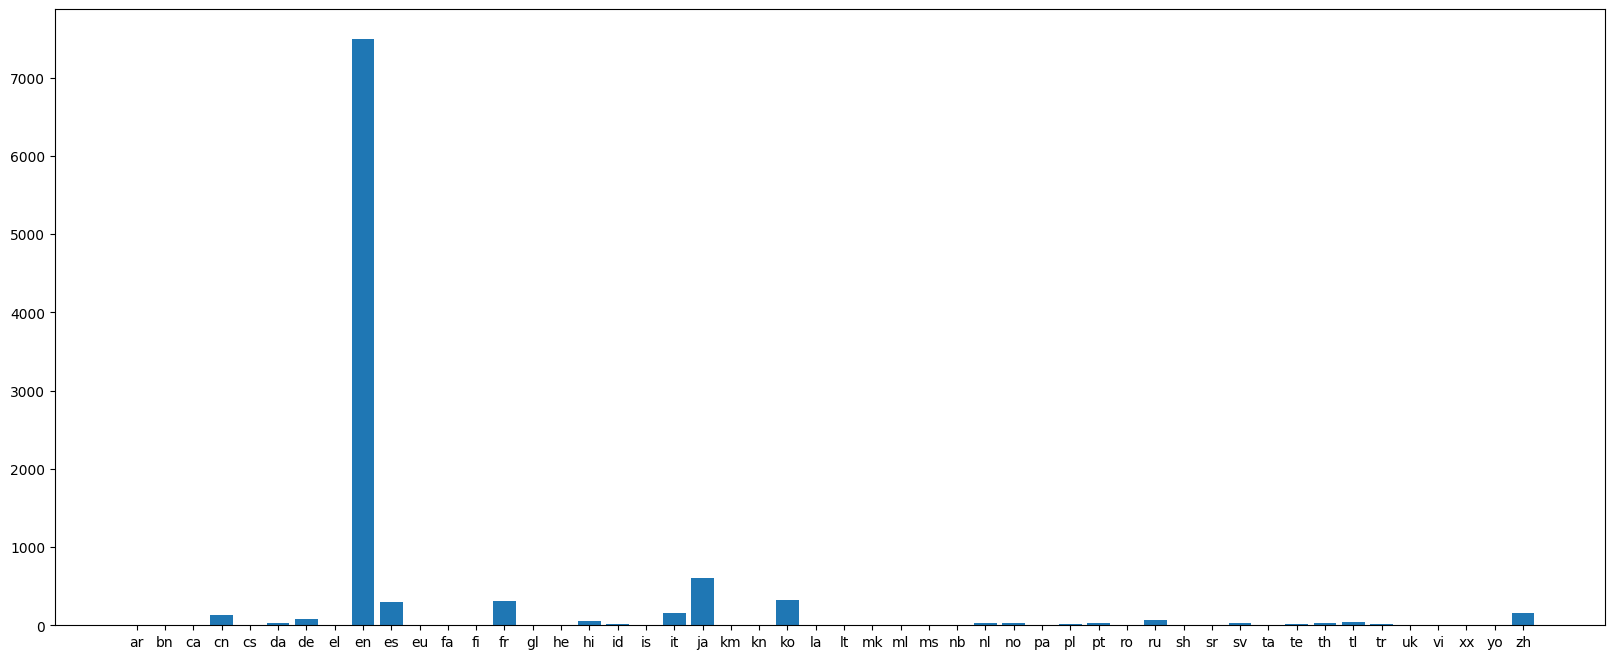

In [116]:
# Visualizing category distribution for original language
plt.figure(figsize=(20, 8))
plt.bar(ol_df.index, ol_df['Id'])

As can be seen, English 'en' has a considerable share compared to other languages. Therefore, we are going to limit this to two categories only, English and not_english

In [118]:
# method to transform OriginalLanguage
def replace_language(item):
    '''function to replace the original language by a binary form'''
    if item == 'en':
        return 1
    else:
        return 0

In [119]:
df['OriginalLanguage'] = df['OriginalLanguage'].apply(replace_language)

In [120]:
df['OriginalLanguage'].head()

0    1
1    1
2    1
3    1
4    0
Name: OriginalLanguage, dtype: int64

In [121]:
df.dtypes

Id                           int64
OriginalLanguage             int64
OriginalTitle               object
Overview                    object
Popularity                 float64
ReleaseDate         datetime64[ns]
Title                       object
VoteAverage                float64
VoteCount                    int64
Budget                       int64
TagLine                     object
RunTime                      int64
Revenue                      int64
Action                       int64
Adventure                    int64
Animation                    int64
Comedy                       int64
Crime                        int64
Documentary                  int64
Drama                        int64
Family                       int64
Fantasy                      int64
History                      int64
Horror                       int64
Music                        int64
Mystery                      int64
Romance                      int64
ScienceFiction               int64
TvMovie             

In [122]:
df.columns

Index(['Id', 'OriginalLanguage', 'OriginalTitle', 'Overview', 'Popularity',
       'ReleaseDate', 'Title', 'VoteAverage', 'VoteCount', 'Budget', 'TagLine',
       'RunTime', 'Revenue', 'Action', 'Adventure', 'Animation', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History ',
       'Horror', 'Music', 'Mystery', 'Romance', 'ScienceFiction', 'TvMovie',
       'Thriller', 'War', 'Western', 'North America', 'Europe', 'Asia',
       'Oceania', 'South America', 'Africa'],
      dtype='object')

Note: In this second section, we discovered the data separating numerical from categoricals, then applied different strategies to transform the categoricals from plain text to numerical values; we had to use some assumptions to reduce the cardinality in some of the categorical data.

### 3. Inspect and impute nulls

In [124]:
#checking number of nulls by column
df.isna().sum()

Id                     0
OriginalLanguage       0
OriginalTitle          0
Overview              51
Popularity             0
ReleaseDate           21
Title                  0
VoteAverage            0
VoteCount              0
Budget                 0
TagLine             2413
RunTime                0
Revenue                0
Action                 0
Adventure              0
Animation              0
Comedy                 0
Crime                  0
Documentary            0
Drama                  0
Family                 0
Fantasy                0
History                0
Horror                 0
Music                  0
Mystery                0
Romance                0
ScienceFiction         0
TvMovie                0
Thriller               0
War                    0
Western                0
North America          0
Europe                 0
Asia                   0
Oceania                0
South America          0
Africa                 0
dtype: int64

In [139]:
#Impute nulls in Overview and TagLinere, placing by empty string

df['Overview'].fillna('', inplace=True)
df['TagLine'].fillna('', inplace=True)

In [134]:
# Remove nulls in ReleaseDate, there are just 21 records and there is not a reasonable way to impute the date of release

df.dropna(subset=['ReleaseDate'], inplace=True)
df.shape


(9979, 38)

In [140]:
#checking number of nulls by column
df.isna().sum()

Id                  0
OriginalLanguage    0
OriginalTitle       0
Overview            0
Popularity          0
ReleaseDate         0
Title               0
VoteAverage         0
VoteCount           0
Budget              0
TagLine             0
RunTime             0
Revenue             0
Action              0
Adventure           0
Animation           0
Comedy              0
Crime               0
Documentary         0
Drama               0
Family              0
Fantasy             0
History             0
Horror              0
Music               0
Mystery             0
Romance             0
ScienceFiction      0
TvMovie             0
Thriller            0
War                 0
Western             0
North America       0
Europe              0
Asia                0
Oceania             0
South America       0
Africa              0
dtype: int64

Note: we removed the nulls by replacing them with empty strings in the text columns and removing the whole rows in ReleaseDate. This last one, considering there were just a few nulls (21) and no reasonable way to impute the values.

### 4. Inspect and correct duplicated rows

In [142]:
df.duplicated().sum()

0

Note: There were not duplicated rows

### 5. create new cleaned dataset (movies_cleaned.csv)

In [146]:
# store final clearned dataset in CSV

df.to_csv('movies_cleaned.csv', index=False)

 ##  Outliers Identification

In [3]:
#reading the clean data
data = pd.read_csv('movies_cleaned.csv', lineterminator='\n', index_col='Id')
data.head()

,OriginalLanguage,OriginalTitle,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount,Budget,TagLine,...,TvMovie,Thriller,War,Western,North America,Europe,Asia,Oceania,South America,Africa
Id,,,,,,,,,,,,,,,,,,,,,
299054,1,Expend4bles,Armed with every weapon they can get their han...,3741.062,2023-09-15,Expend4bles,6.4,364,100000000,They'll die when they're dead.,...,0,1,0,0,0,0,0,0,0,0
926393,1,The Equalizer 3,Robert McCall finds himself at home in Souther...,2471.515,2023-08-30,The Equalizer 3,7.3,1027,70000000,Justice knows no borders.,...,0,1,0,0,1,0,0,0,0,0
1034062,1,Mortal Kombat Legends: Cage Match,"In 1980s Hollywood, action star Johnny Cage is...",2223.430,2023-10-17,Mortal Kombat Legends: Cage Match,7.8,27,0,Neon lights... Suits with shoulder pads... Jum...,...,0,0,0,0,1,0,0,0,0,0
575264,1,Mission: Impossible - Dead Reckoning Part One,Ethan Hunt and his IMF team embark on their mo...,2032.927,2023-07-08,Mission: Impossible - Dead Reckoning Part One,7.7,1799,291000000,We all share the same fate.,...,0,1,0,0,1,0,0,0,0,0
1151534,0,Nowhere,A young pregnant woman named Mia escapes from ...,1627.678,2023-09-29,Nowhere,7.6,686,0,Attempting to survive in the middle of nowhere...,...,0,1,0,0,0,0,0,0,0,0


In [12]:
# Indentifing the numercial columns in the clean dataset
data.select_dtypes(include=['int', 'float']).columns

Index(['OriginalLanguage', 'Popularity', 'VoteAverage', 'VoteCount', 'Budget',
       'RunTime', 'Revenue', 'Action', 'Adventure', 'Animation', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History ',
       'Horror', 'Music', 'Mystery', 'Romance', 'ScienceFiction', 'TvMovie',
       'Thriller', 'War', 'Western', 'North America', 'Europe', 'Asia',
       'Oceania', 'South America', 'Africa'],
      dtype='object')

In [4]:
# Filtering out the discrete numerical columns (those are categorical that were enconded in previous steps)
numerical_columns = ['Popularity', 'VoteAverage', 'VoteCount', 'Budget','RunTime', 'Revenue']
numerical_df = data[numerical_columns]

In [5]:
numerical_df.describe()

,Popularity,VoteAverage,VoteCount,Budget,RunTime,Revenue
count,9979.000000,9979.000000,9979.000000,9.979000e+03,9979.000000,9.979000e+03
mean,34.276587,6.380619,1623.563082,2.048210e+07,101.937268,6.238473e+07
std,84.418679,1.352348,2962.822512,3.881605e+07,27.358958,1.563777e+08
min,13.049000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,15.589500,6.000000,170.000000,0.000000e+00,91.000000,0.000000e+00
50%,20.099000,6.600000,564.000000,2.200000e+06,101.000000,3.775000e+06
75%,30.352500,7.100000,1668.000000,2.500000e+07,115.000000,5.461456e+07
max,3741.062000,10.000000,34628.000000,4.600000e+08,400.000000,2.923706e+09


### Boxplots

In [6]:
# Function to create boxplot to see percetiles and outliers presence

def create_box_plot(column, title, r1, r2):
    q3 = np.percentile(column, 75)
    q1 = np.percentile(column, 25)
    IQR = q3 - q1
    upper_fence = q3 + IQR * 1.5
    lower_fence = q1 - IQR * 1.5

    fig = plt.figure(1, figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.set_title(title + " Boxplot")
    
    r1 = min(r1, lower_fence)
    r2 = max(r2, upper_fence)

    ax.boxplot(column , vert=False, manage_ticks=True)
    ax.set_xlabel('values')
    ax.set_yticks([1])
    ax.set_yticklabels([title])

    quantiles = np.quantile(column , np.array([0.00, 0.25, 0.50, 0.75]))
    quantiles = np.append(quantiles, upper_fence)
    quantiles = np.insert(quantiles, 0, lower_fence)
    ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
              color='b', ls=':', lw=0.5, zorder=0)
    ax.set_ylim(0.5, 1.5)
    ax.set_xticks(quantiles)
    plt.xlim(r1, r2)
    ax.tick_params(axis='x', labelsize=8)
    plt.show()

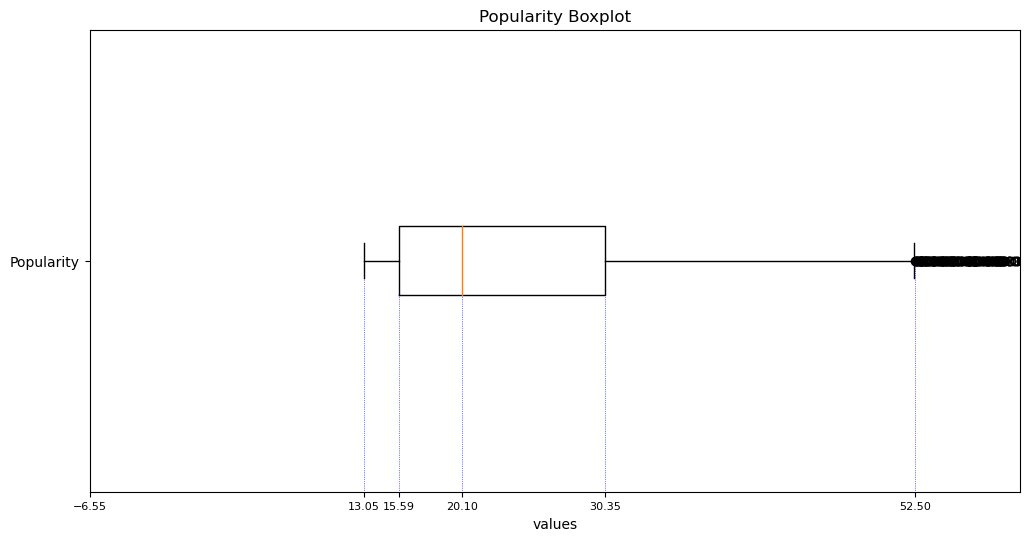

In [4]:
# Popularity Boxplot
create_box_plot(data['Popularity'], 'Popularity', 0, 60)

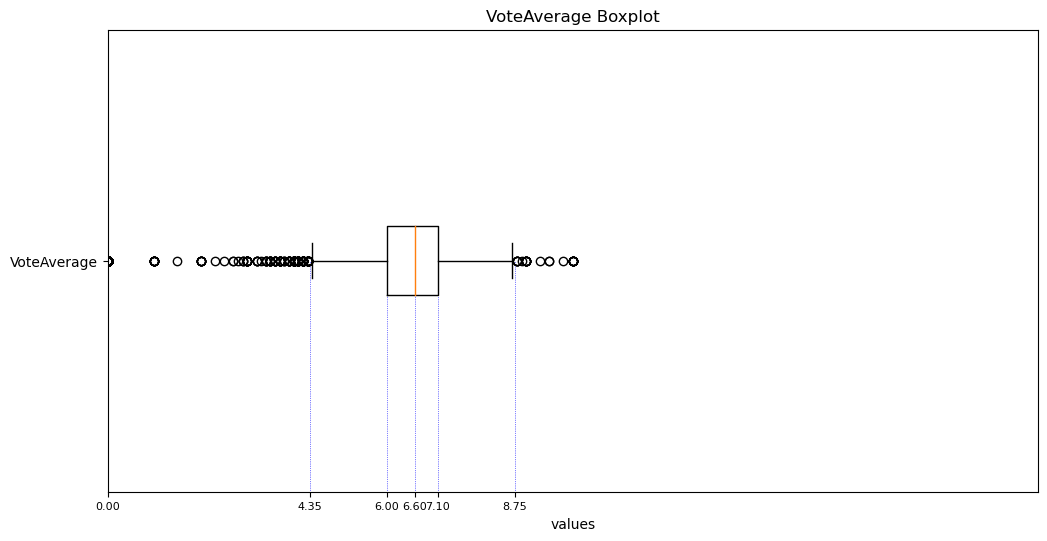

In [5]:
# VoteAverage Boxplot
create_box_plot(data['VoteAverage'], 'VoteAverage', 0, 20)

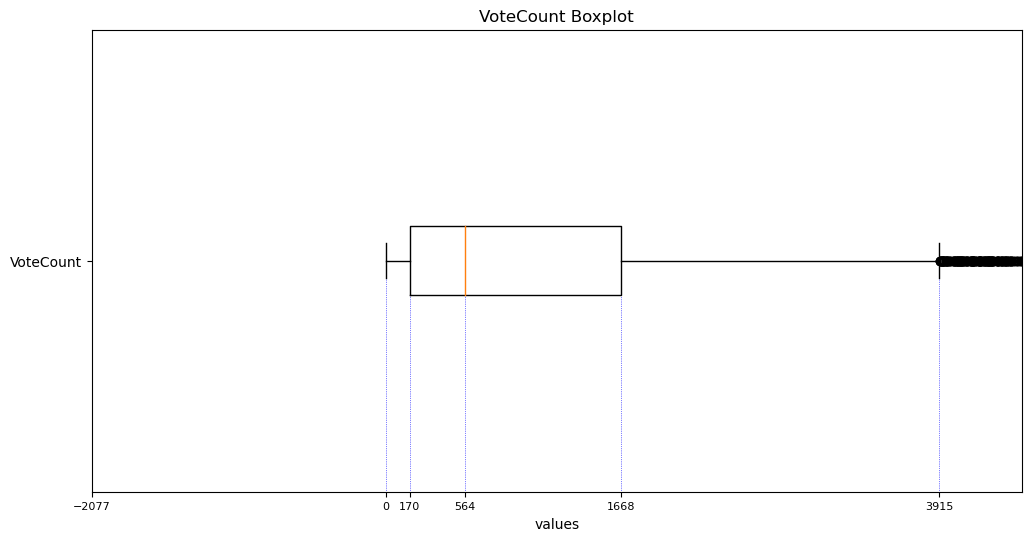

In [6]:
# VoteCount Boxplot
create_box_plot(data['VoteCount'], 'VoteCount', 0, 4500)

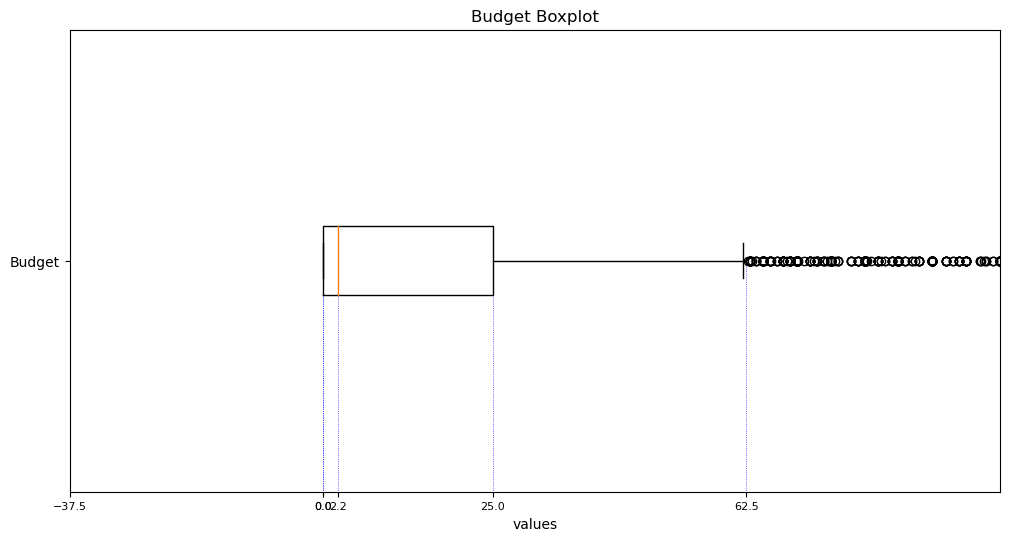

In [7]:
# Scaled Budget Boxplot
create_box_plot((data['Budget']) / 1000000, 'Budget', 0, 100)

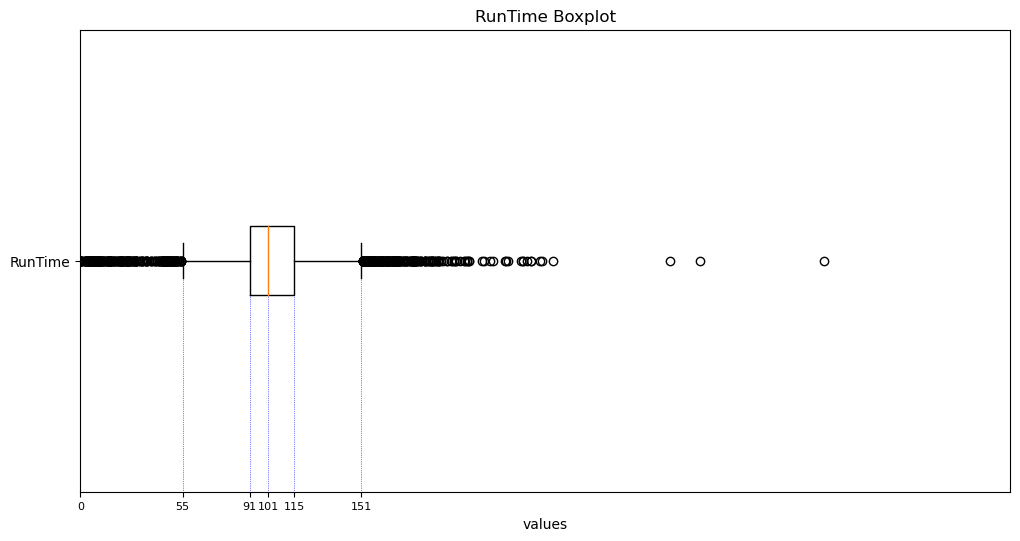

In [8]:
# RunTime Boxplot
create_box_plot(data['RunTime'], 'RunTime', 0, 500)

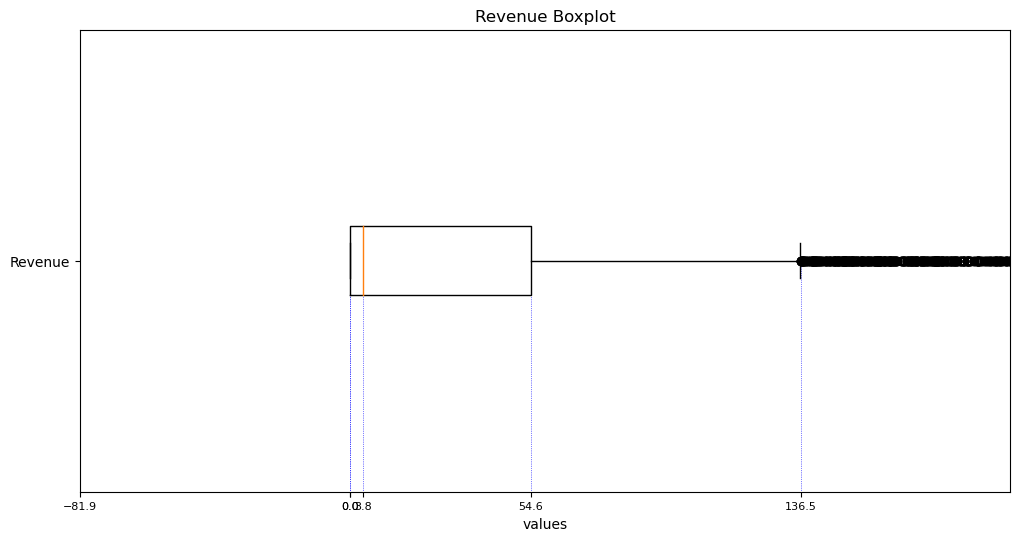

In [9]:
# Scaled Revenue Boxplot
create_box_plot((data['Revenue'] / 1000000), 'Revenue', 0, 200)

Notes:

The function "create_box_plot" was created to inspect the outliers in the columns visually:

1. The function accepts three arguments; "column" which is the data for the boxplot, "title" which impacts the title and label we want to add to the boxplot. And (r1,r2), which is the range of data we want to plot.
2. It calculates the percentiles q3, q1, and the IQR to compute the upper and lower fences to be included in the boxplot.
3. The quantiles  [0, 25, 50, 75] are calculated and stored in an array called "quantiles". The array is modified with the lower fence at position 0 and the upper fence at the last position.
4. The quantiles array is passed to the method, .vlines which handles the vertical lines
5. The quantiles array is also passed to the .set_xticks to see the numbers in the x-axis in the boxplot
6. Finally, the range in X to plot is established using the method .xlim

The plots show:

1. Popularity: Shows a distribution positively skewed (right-skewed) and the presence of outliers in the upper level. 25% of the data fall below 15.59, 50% of the data fall below 20.1, 75% of the data fall below 30.33. The upper extreme is at 52, and the lower extreme is at 13.05.

2. VoteAverage: This shows a symmetric distribution and the presence of outliers in the upper and lower levels. 25% of the data fall below 6.00, 50% of the data fall below 6.60, 75% of the data fall below 7.10. The upper extreme is at 8.75, and the lower extreme is at 4.35.

3. VoteCount: Shows a distribution positively skewed (right-skewed) and the presence of outliers in the upper level. 25% of the data fall below 170, 50% of the data fall below 564, and 75% of the data fall below 1668. The upper extreme is at 3915, and the lower extreme is at 0.

4. Budget: The budget was scaled down to facilitate plotting. It shows a distribution positively skewed (right-skewed) and the presence of outliers in the upper level. 50% of the data fall below 2.2M, and 75% of the data fall below 25M. The upper extreme is at 62.5M, and the lower extreme is at 0.

5. RunTime: Shows a symmetric distribution and the presence of outliers in the upper and lower levels. 25% of the data fall below 91 min, 50% of the data fall below 101 min, and 75% of the data fall below 115 min. The upper extreme is at 151 min, and the lower extreme is at 55 min.

6. Revenue: Revenue was scaled down to facilitate plotting. It shows a distribution positively skewed (right-skewed) and the presence of outliers in the upper level. 50% of the data fall below 8.8 M, and 75% of the data fall below 54.6 M. The upper extreme is at 136.5 M, and the lower extreme is at 0.




## Outliers Handling

### Method 1: Quantile-based Flooring and Capping

In [7]:
# Function to apply flooring and capping method for outlier handling

def apply_flooring_capping(data, floor, cap):
    floor_q = data.quantile(0.01)
    cap_q = data.quantile(0.99)
    result = data.copy()
    result = np.where(result < floor_q, floor_q, result)
    result = np.where(result > cap_q, cap_q, result)
    return result
    

In [8]:
# Function to plot two boxplot
def create_boxplots(arr1, arr2, r1, r2, label1, label2):
    ax = sns.boxplot(data=[arr1, arr2], orient='h')
    plt.xlim(r1, r2)
    ax.set_yticklabels([label1, label2]) 

In [12]:
# Applying quantile-based flooring and capping to Popularity

popularity_fc = apply_flooring_capping(data['Popularity'], 0.01, 0.99)

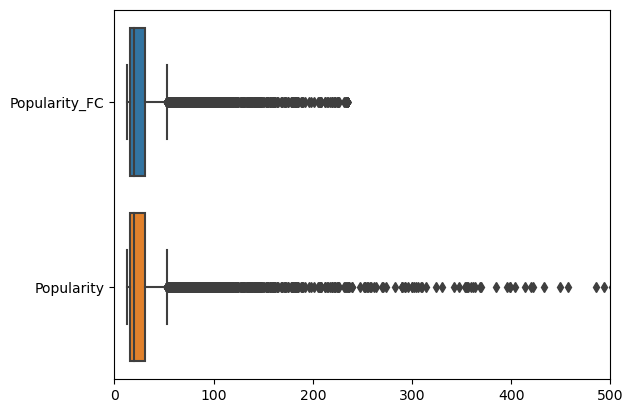

In [113]:
# Boxplots to compate Popularity with and without quantile-based flooring and capping
create_boxplots(popularity_fc, data['Popularity'], 0, 500, 'Popularity_FC', 'Popularity')

In [110]:
# Applying quantile-based flooring and capping to VoteAverage

vote_average_fc = apply_flooring_capping(data['VoteAverage'], 0.01, 0.99)

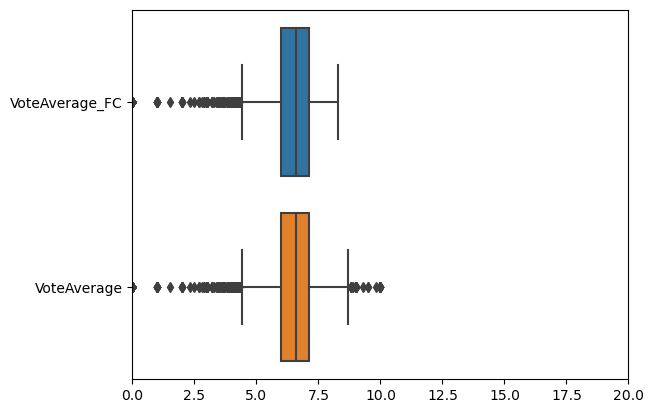

In [111]:
# Boxplots to compate VoteAverage with and without quantile-based flooring and capping
create_boxplots(vote_average_fc, data['VoteAverage'], 0, 20, 'VoteAverage_FC', 'VoteAverage')

In [16]:
# Applying quantile-based flooring and capping to VoteCount

vote_count_fc = apply_flooring_capping(data['VoteCount'], 0.01, 0.99)

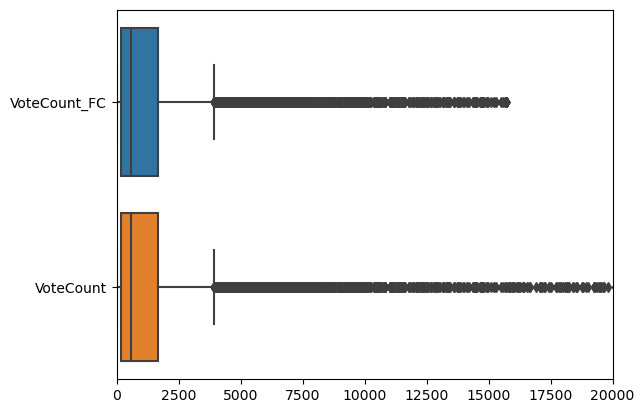

In [17]:
# Boxplots to compate VoteCount with and without quantile-based flooring and capping
create_boxplots(vote_count_fc, data['VoteCount'], 0, 20000, 'VoteCount_FC', 'VoteCount')

In [18]:
# Applying quantile-based flooring and capping to Budget

budget_fc = apply_flooring_capping(data['Budget'], 0.01, 0.99)

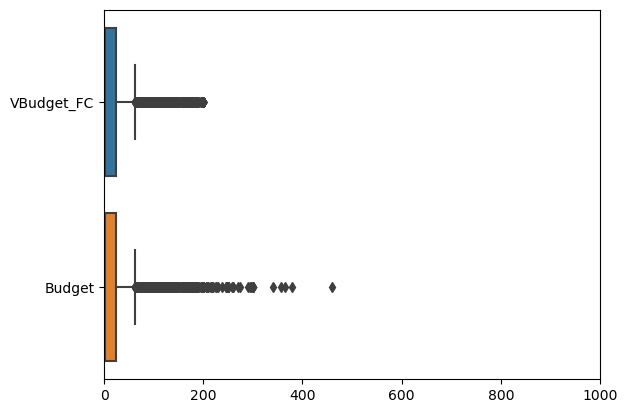

In [19]:
# Boxplots to compate VoteCount with and without quantile-based flooring and capping
create_boxplots(budget_fc / 1000000, data['Budget'] / 1000000, 0, 1000, 'VBudget_FC', 'Budget')

In [20]:
# Applying quantile-based flooring and capping to RunTime

runtime_fc = apply_flooring_capping(data['RunTime'], 0.01, 0.99)

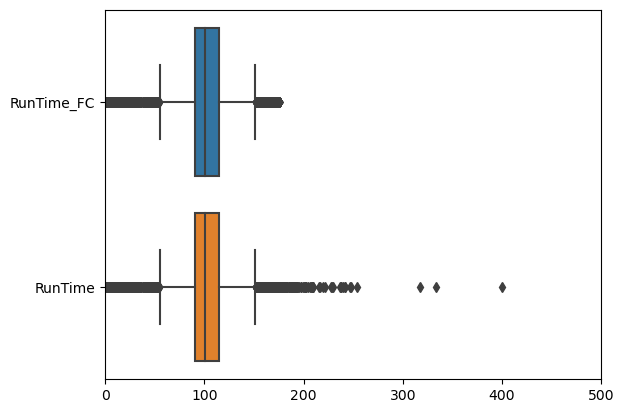

In [21]:
# Boxplots to compate RunTime with and without quantile-based flooring and capping
create_boxplots(runtime_fc, data['RunTime'], 0, 500, 'RunTime_FC', 'RunTime')

In [22]:
# Applying quantile-based flooring and capping to Revenue

revenue_fc = apply_flooring_capping(data['Revenue'], 0.01, 0.99)

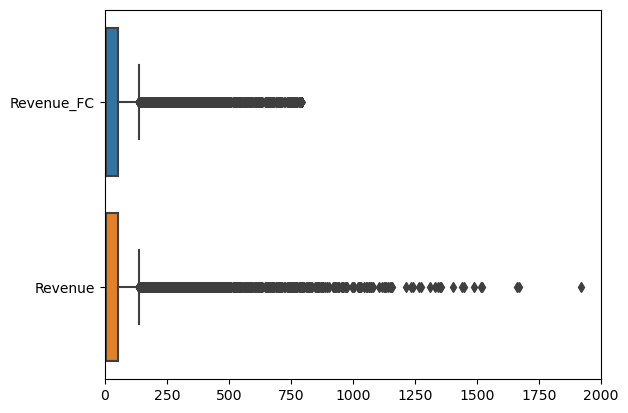

In [23]:
# Boxplots to compate RunTime with and without quantile-based flooring and capping
create_boxplots(revenue_fc / 1000000, data['Revenue'] / 1000000, 0, 2000, 'Revenue_FC', 'Revenue')

### Method 2: Trimming 

In [9]:
numerical_columns = ['Popularity', 'VoteAverage', 'VoteCount', 'Budget','RunTime', 'Revenue']

In [10]:
# method to return a copy of a data frame after trimming the numerical valiables
def get_trimmed_data(data, numerical_columns):
    result = data.copy()
    for col in numerical_columns:
        upper_q = np.quantile(data[col], 0.75)
        lower_q = np.quantile(data[col], 0.25)
        IQR = upper_q - lower_q
        upper_whisker = upper_q + (1.5 * IQR)
        lower_whisker = lower_q - (1.5 * IQR)
        indexes = result[(result[col] > upper_whisker) | (result[col] < lower_whisker)].index
        print(f'Droping {indexes.shape[0]} indexes for {col}')
        result.drop(indexes, inplace=True)
        print(f'Data final shape {result.shape}')
    return result  
    

In [11]:
# getting trimmed new data
trimmed_data = get_trimmed_data(data, numerical_columns)

Droping 1035 indexes for Popularity
Data final shape (8944, 37)
Droping 421 indexes for VoteAverage
Data final shape (8523, 37)
Droping 662 indexes for VoteCount
Data final shape (7861, 37)
Droping 389 indexes for Budget
Data final shape (7472, 37)
Droping 420 indexes for RunTime
Data final shape (7052, 37)
Droping 258 indexes for Revenue
Data final shape (6794, 37)


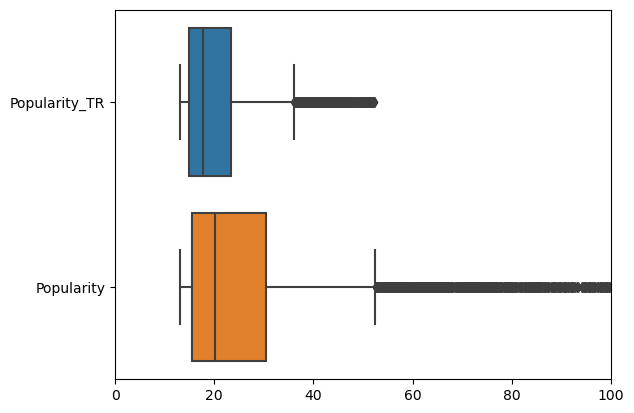

In [13]:
# Boxplots to compare trimmed and no-trimmed Popularity
create_boxplots(trimmed_data['Popularity'], data['Popularity'], 0, 100, 'Popularity_TR', 'Popularity')

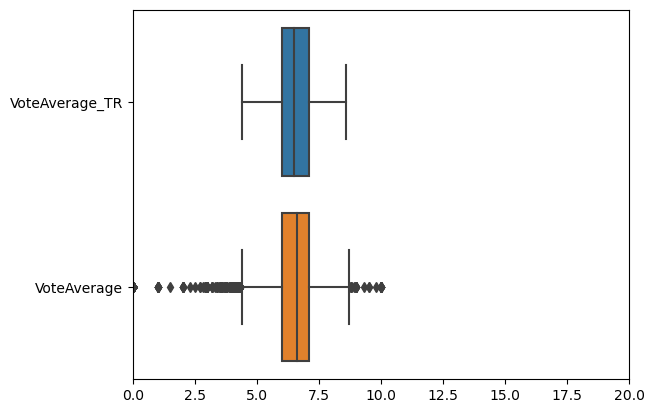

In [44]:
# Boxplots to compare trimmed and no-trimmed 'VoteAverage'
create_boxplots(trimmed_data['VoteAverage'], data['VoteAverage'], 0, 20, 'VoteAverage_TR', 'VoteAverage')

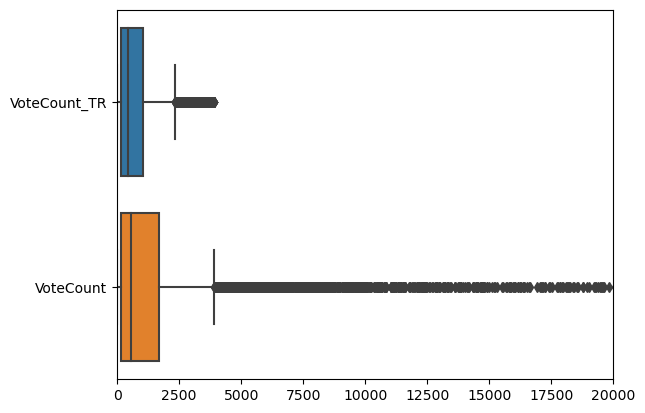

In [45]:
# Boxplots to compare trimmed and no-trimmed VoteCount
create_boxplots(trimmed_data['VoteCount'], data['VoteCount'], 0, 20000, 'VoteCount_TR', 'VoteCount')

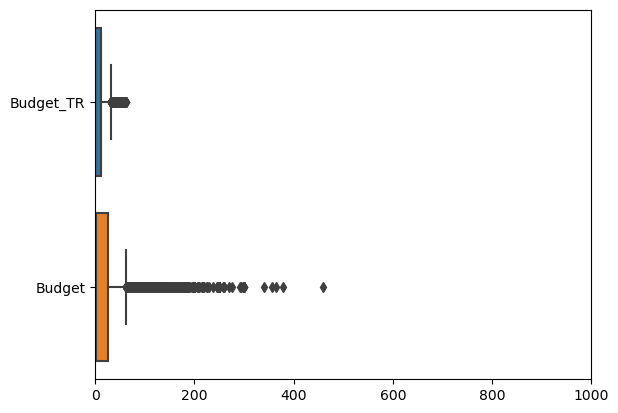

In [46]:
# Boxplots to compare trimmed and no-trimmed Budget
create_boxplots(trimmed_data['Budget'] / 1000000, data['Budget'] / 1000000, 0, 1000, 'Budget_TR', 'Budget')

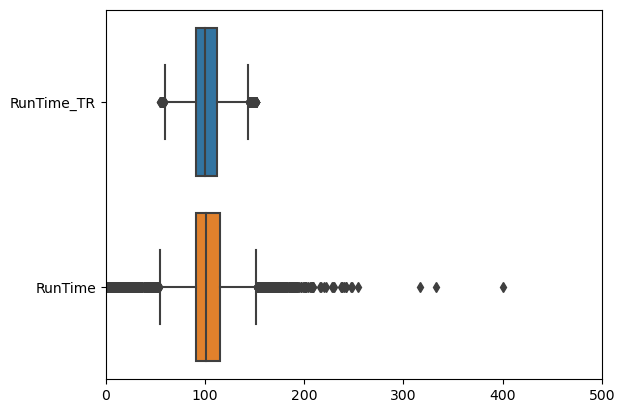

In [47]:
# Boxplots to compare trimmed and no-trimmed RunTime
create_boxplots(trimmed_data['RunTime'], data['RunTime'], 0, 500, 'RunTime_TR', 'RunTime')

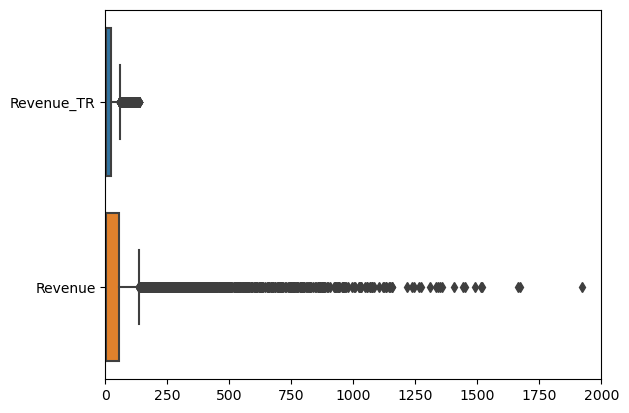

In [48]:
# Boxplots to compare trimmed and no-trimmed Revenue
create_boxplots(trimmed_data['Revenue'] / 1000000, data['Revenue']/1000000, 0, 2000, 'Revenue_TR', 'Revenue')

### Method 3: Log Transformation

In [41]:
# Function to apply log tranformation to data, returns a copy with transformed columns
def get_log_transformed_data(data, numerical_columns):
    result = data.copy()
    for col in numerical_columns:
        result[col] = result[col].map(lambda x: np.log(x) if x > 0 else 0)
    return result
    

In [13]:
# create graph to compare boxplots
def pair_boxplots(arr1, arr2, label1, label2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].boxplot(arr1, vert=False)
    axes[0].set_title(f'Boxplot {label1}')
    axes[1].boxplot(arr2, vert=False)
    axes[1].set_title(f'Boxplot {label2}')
    plt.show()
    
# create graph to compare histograms
def pair_histograms(arr1, arr2, label1, label2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].hist(arr1, bins=20)
    axes[0].set_title(f'Histogram {label1}')
    axes[1].hist(arr2, bins=20)
    axes[1].set_title(f'Histogram {label2}')
    plt.show()


In [33]:
# Understanding skewness correction for Popularity
log_transformed_data = get_log_transformed_data(data, numerical_columns)
skewness_td = log_transformed_data['Popularity'].skew().round(2)
skewness_d = data['Popularity'].skew().round(2)
print(f'Skewness transformed data {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data 2.13
Skewness data: 20.15


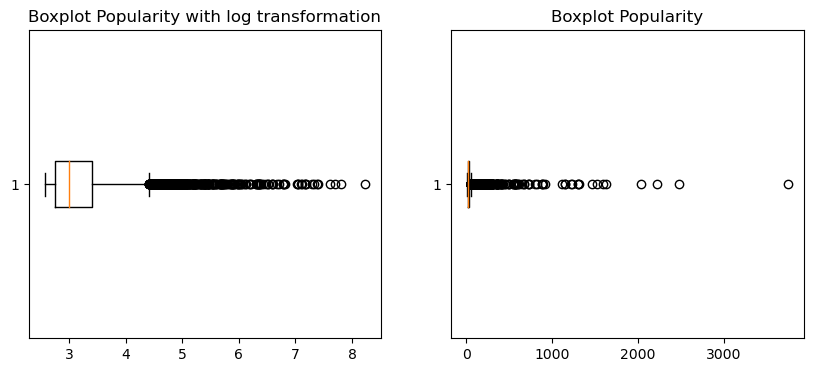

In [82]:
# boxplots for Popularity with and without log transformation
pair_boxplots(log_transformed_data['Popularity'], data['Popularity'], 'Popularity with log transformation', 'Popularity')

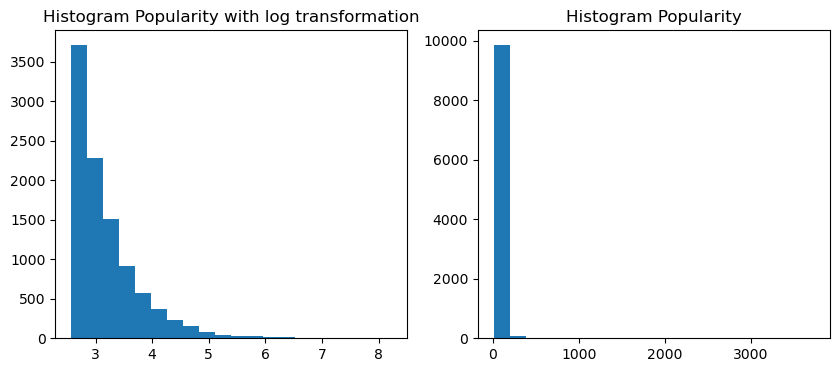

In [83]:
# histograms for Popularity with and without log transformation
pair_histograms(log_transformed_data['Popularity'], data['Popularity'], 'Popularity with log transformation', 'Popularity')

In [99]:
# Understanding skewness correction for VoteAverage
skewness_td = log_transformed_data['VoteAverage'].skew().round(2)
skewness_d = data['VoteAverage'].skew().round(2)
print(f'Skewness transformed data: {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data: -4.37
Skewness data: -2.59


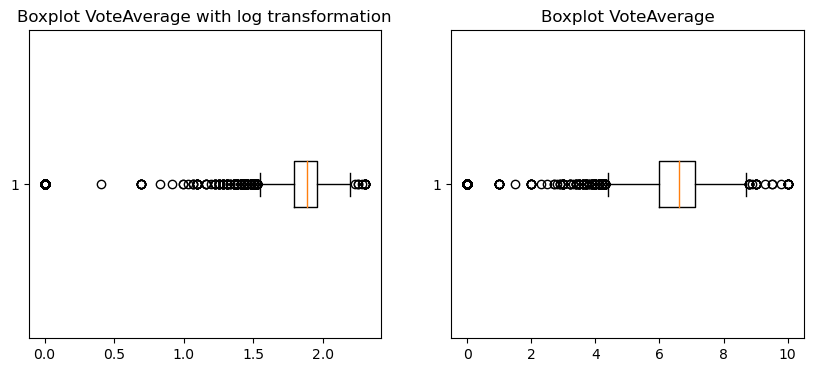

In [86]:
# boxplots for VoteAverage with and without log transformation
pair_boxplots(log_transformed_data['VoteAverage'], data['VoteAverage'], 'VoteAverage with log transformation', 'VoteAverage')

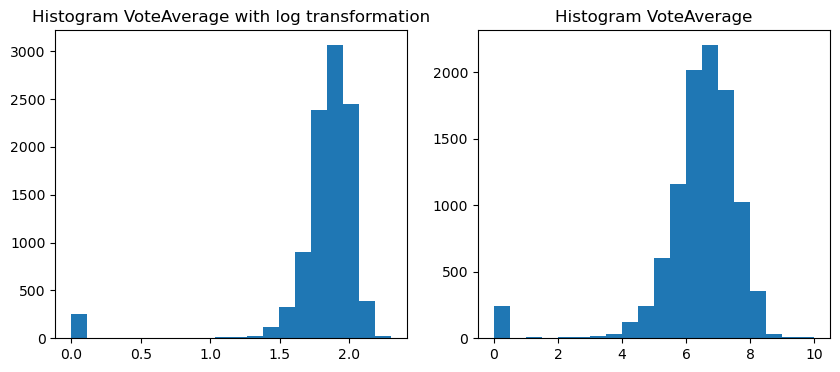

In [87]:
# histograms for VoteAverage with and without log transformation
pair_histograms(log_transformed_data['VoteAverage'], data['VoteAverage'], 'VoteAverage with log transformation', 'VoteAverage')

In [98]:
# Understanding skewness correction for VoteCount
skewness_td = log_transformed_data['VoteCount'].skew().round(2)
skewness_d = data['VoteCount'].skew().round(2)
print(f'Skewness transformed data: {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data: -0.98
Skewness data: 4.04


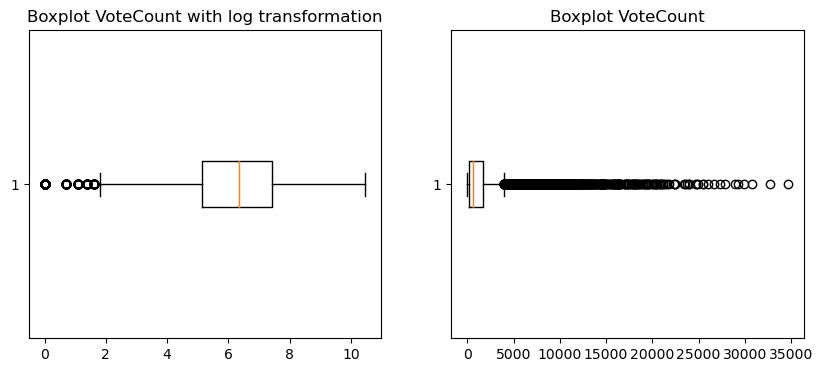

In [88]:
# boxplots for VoteCount with and without log transformation
pair_boxplots(log_transformed_data['VoteCount'], data['VoteCount'], 'VoteCount with log transformation', 'VoteCount')

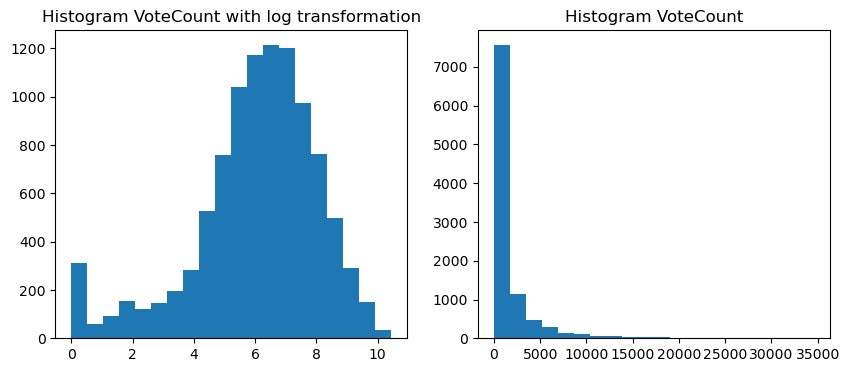

In [89]:
# histograms for VoteCount with and without log transformation
pair_histograms(log_transformed_data['VoteCount'], data['VoteCount'], 'VoteCount with log transformation', 'VoteCount')

In [103]:
#Understanding skewness correction for Budget
skewness_td = log_transformed_data['Budget'].skew().round(2)
skewness_d = data['Budget'].skew().round(2)
print(f'Skewness transformed data: {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data: -0.16
Skewness data: 3.24


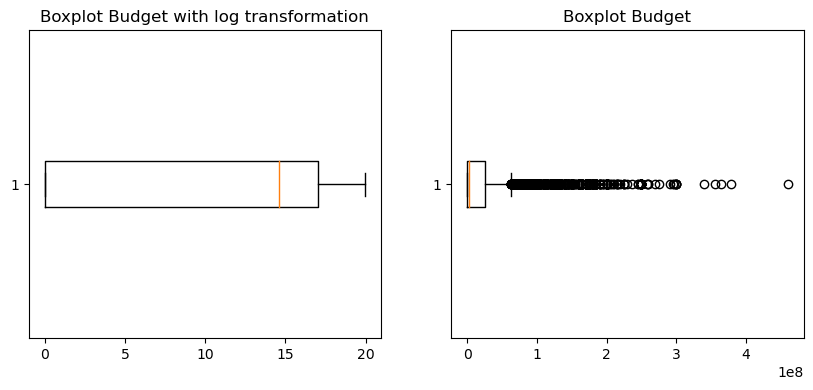

In [90]:
# boxplots for Budget with and without log transformation
pair_boxplots(log_transformed_data['Budget'], data['Budget'], 'Budget with log transformation', 'Budget')

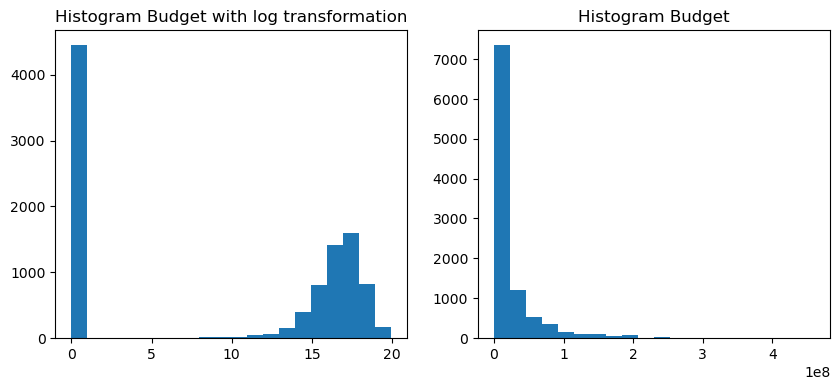

In [91]:
# histograms for Popularity with and without log transformation
pair_histograms(log_transformed_data['Budget'], data['Budget'], 'Budget with log transformation', 'Budget')

In [102]:
# Understanding skewness correction for RunTime
skewness_td = log_transformed_data['RunTime'].skew().round(2)
skewness_d = data['RunTime'].skew().round(2)
print(f'Skewness transformed data: {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data: -5.55
Skewness data: -0.35


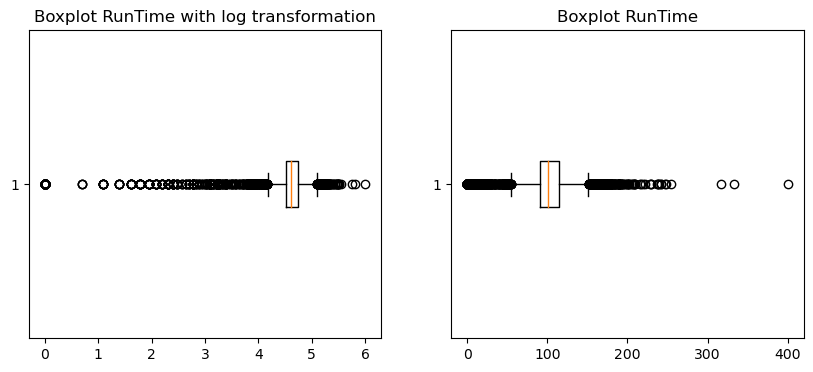

In [92]:
# boxplots for RunTime with and without log transformation
pair_boxplots(log_transformed_data['RunTime'], data['RunTime'], 'RunTime with log transformation', 'RunTime')

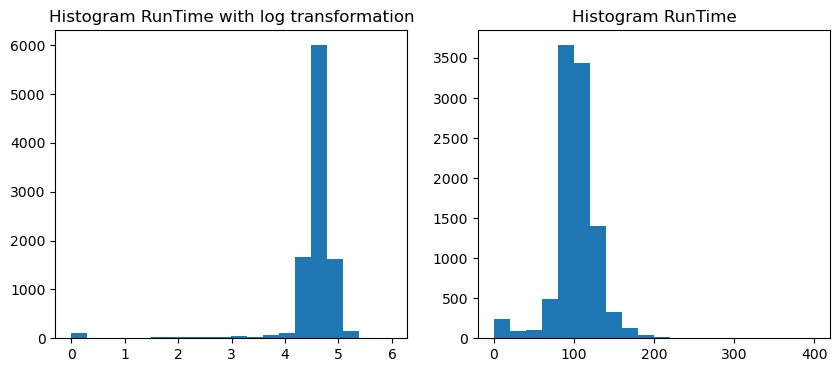

In [93]:
# histograms for RunTime with and without log transformation
pair_histograms(log_transformed_data['RunTime'], data['RunTime'], 'RunTime with log transformation', 'RunTime')

In [101]:
# Understanding skewness correction for Revenue
skewness_td = log_transformed_data['Revenue'].skew().round(2)
skewness_d = data['Revenue'].skew().round(2)
print(f'Skewness transformed data: {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data: -0.25
Skewness data: 5.89


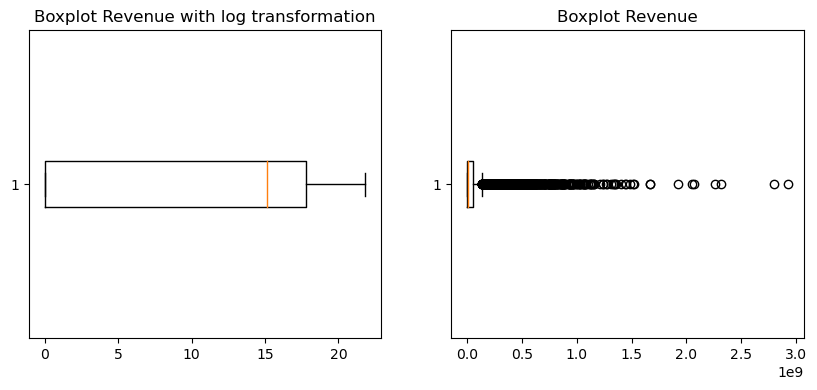

In [94]:
# boxplots for Revenue with and without log transformation
pair_boxplots(log_transformed_data['Revenue'], data['Revenue'], 'Revenue with log transformation', 'Revenue')

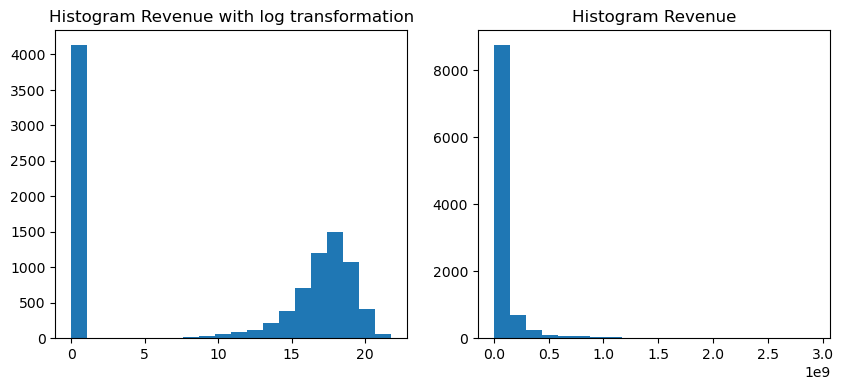

In [95]:
# histograms for Revenue with and without log transformation
pair_histograms(log_transformed_data['Revenue'], data['Revenue'], 'Revenue with log transformation', 'Revenue')

In [34]:
# applying Trimming to log transformed Popularity
logt_trimmed_data = get_trimmed_data(log_transformed_data, ['Popularity'])

Droping 482 indexes for Popularity
Data final shape (9497, 37)


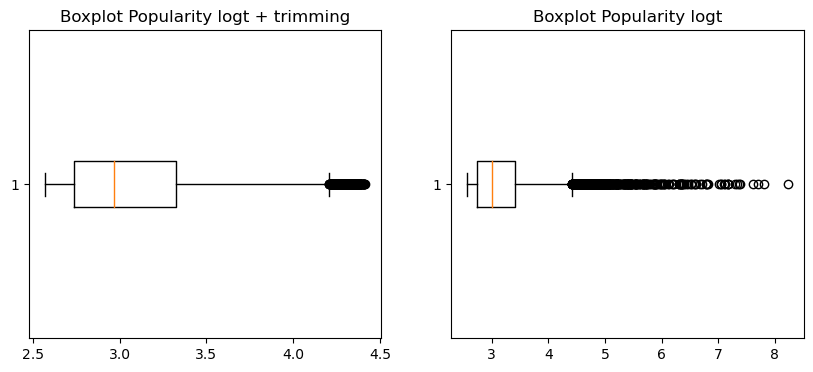

In [35]:
# final Popularity log transformation + trimming

pair_boxplots(logt_trimmed_data['Popularity'], log_transformed_data['Popularity'], 'Popularity logt + trimming', 'Popularity logt')

In [42]:
# final dataset without outliers

# 1 Trimming columns 'VoteAverage' and 'RunTime'
movies_data_trimmed = get_trimmed_data(data, ['VoteAverage', 'RunTime'])

# Log tranformation for 'Budget', 'Revenue', 'VoteCount' and 'Popularity'
movies_data_log_transform = get_log_transformed_data(movies_data_trimmed, ['Budget', 'Revenue', 'VoteCount', 'Popularity'])

# Apply trimming to the log tranformed 'Popularity'

movies_data = get_trimmed_data(movies_data_log_transform, ['Popularity'])


Droping 446 indexes for VoteAverage
Data final shape (9533, 37)
Droping 560 indexes for RunTime
Data final shape (8973, 37)
Droping 421 indexes for Popularity
Data final shape (8552, 37)


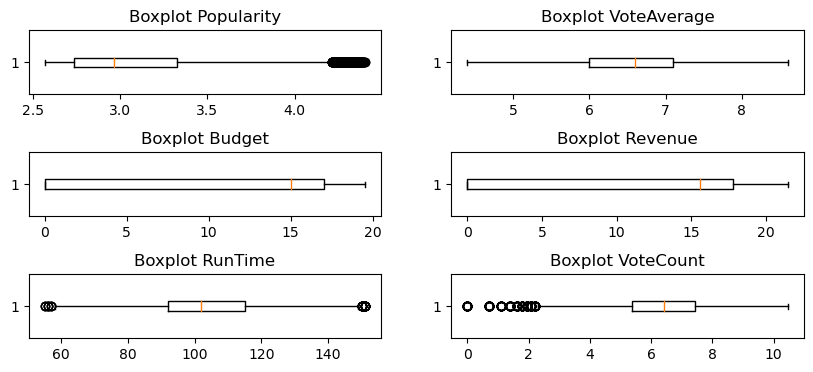

In [48]:
# boxplot to final confirm all distributions

fig, axes = plt.subplots(3, 2, figsize=(10, 4))
plt.subplots_adjust(hspace=0.9)
axes[0][0].boxplot(movies_data['Popularity'], vert=False)
axes[0][0].set_title('Boxplot Popularity')
axes[0][1].boxplot(movies_data['VoteAverage'], vert=False)
axes[0][1].set_title('Boxplot VoteAverage')
axes[1][0].boxplot(movies_data['Budget'], vert=False)
axes[1][0].set_title('Boxplot Budget')
axes[1][1].boxplot(movies_data['Revenue'], vert=False)
axes[1][1].set_title('Boxplot Revenue')
axes[2][0].boxplot(movies_data['RunTime'], vert=False)
axes[2][0].set_title('Boxplot RunTime')
axes[2][1].boxplot(movies_data['VoteCount'], vert=False)
axes[2][1].set_title('Boxplot VoteCount')
plt.show()


In [52]:
# storing the final dataset as movies_data.csv
movies_data.to_csv('movies_data.csv')

In [54]:
#reading the data without outliers
data = pd.read_csv('movies_data.csv', lineterminator='\n', index_col='Id')
data.head(2)

,OriginalLanguage,OriginalTitle,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount,Budget,TagLine,...,TvMovie,Thriller,War,Western,North America,Europe,Asia,Oceania,South America,Africa
Id,,,,,,,,,,,,,,,,,,,,,
27205,1,Inception,"Cobb, a skilled thief who commits corporate es...",4.401216,2010-07-15,Inception,8.4,10.452418,18.890684,Your mind is the scene of the crime.,...,0,0,0,0,1,1,0,0,0,0
497698,1,Black Widow,"Natasha Romanoff, also known as Black Widow, c...",4.399596,2021-07-07,Black Widow,7.3,9.142918,19.113828,Her world. Her secrets. Her legacy.,...,0,0,0,0,1,0,0,0,0,0


Notes:

Quantile-based Flooring and Capping:

- Overall, it showed an improvement in skewness. However, for all the columns, we still got a significant presence of outliers.

Trimming:

- This method is not an option as a unique method to fix outliers due to a significant data loss. After trimming, the number of rows was reduced from 9979 to just 6796 (32%). Additionally, in terms of improving outliers, although it reduced the skewness for some columns, it was more effective for 'VoteAverage' and 'RunTime' (both have the most symmetric distributions). The other columns still have a significant presence of outliers.
    
Log Transformation

- This method presents a small change for those columns that already have a symmetrical distribution, such as RunTime and VoteAverage. On the other hand, for those skewed distributions, this method allowed a more symmetrical one, as seen in Popularity, VoteCount, Budget, and Revenue.

- This transformation successfully removed outliers for 'Budget', 'Revenue' and 'VoteCount'. Additionally, it improved the distributions for Popularity and VoteCount.

Considering the results applying each of the methods for all the columns, we decided to remove the outliers as follows:

- 'VoteAverage' and 'RunTime' -> Trimming
- 'Budget', 'Revenue' and VoteCount-> Log Tranformation
- 'Popularity' -> Log Tranformation + Trimming

Using above strategy, we were able to remove ourliers and improve skewness for the columns.

Finally, we stored the dataset as movies_data.csv





In [5]:
import pandas as pd

data = pd.read_csv('movies_data.csv', lineterminator='\n', index_col='Id')
data.head(2)

,OriginalLanguage,OriginalTitle,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount,Budget,TagLine,...,TvMovie,Thriller,War,Western,North America,Europe,Asia,Oceania,South America,Africa
Id,,,,,,,,,,,,,,,,,,,,,
27205,1,Inception,"Cobb, a skilled thief who commits corporate es...",4.401216,2010-07-15,Inception,8.4,10.452418,18.890684,Your mind is the scene of the crime.,...,0,0,0,0,1,1,0,0,0,0
497698,1,Black Widow,"Natasha Romanoff, also known as Black Widow, c...",4.399596,2021-07-07,Black Widow,7.3,9.142918,19.113828,Her world. Her secrets. Her legacy.,...,0,0,0,0,1,0,0,0,0,0


Remove punctuations, numbers and stop words

In [21]:
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import string

nltk.download('stopwords')

# Remove stop words
eng_stop_words = stopwords.words('english')
def process_text(text):
    """
    Process a string to remove stop words
    """
    
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Tokenize and remove stop words
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in eng_stop_words and not word.isnumeric()]
    return " ".join(filtered_words)

data['OriginalTitle'] = data['OriginalTitle'].apply(process_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acorr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Word cloud

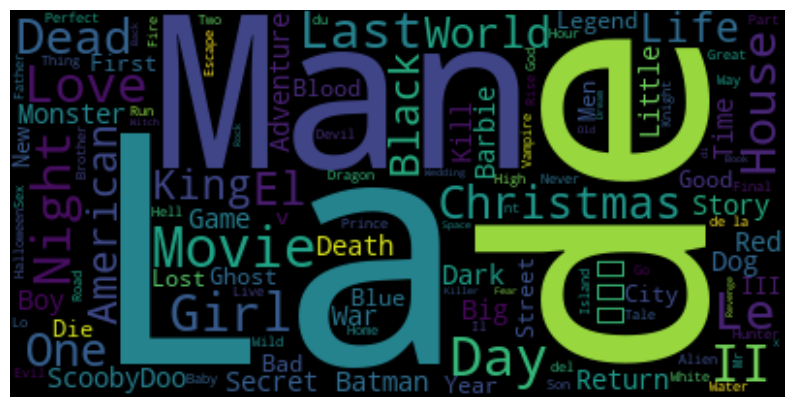

In [22]:
text = ' '.join(data['OriginalTitle'])
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()